In [33]:
import matplotlib.pyplot as plt

import numpy as np
import cv2
import keras
from keras.models import Sequential
from keras.layers import Flatten, Dense, BatchNormalization, Dropout
from keras.applications import VGG16
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.datasets import fashion_mnist

Завантаження та нормалізація даних

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
# Ресайз зображень та конвертація в колір
x_train_resized = np.array([cv2.resize(img, (48, 48)) for img in x_train])
x_test_resized = np.array([cv2.resize(img, (48, 48)) for img in x_test])
x_train_rgb = np.stack([x_train_resized] * 3, axis=-1)
x_test_rgb = np.stack([x_test_resized] * 3, axis=-1)

# Нормалізація значень пікселів до діапазону [0, 1]
x_train_rgb = x_train_rgb.astype('float32') / 255.0
x_test_rgb = x_test_rgb.astype('float32') / 255.0

# Категоріальне кодування міток
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(x_train_rgb, y_train, test_size=0.2, random_state=42)


In [ ]:
print(x_train.shape, x_temp.shape, y_train.shape, y_temp.shape)

(48000, 48, 48, 3) (12000, 48, 48, 3) (48000, 10) (12000, 10)


# Створення моделі згорткової нейромережі з VGG16

In [ ]:
model = Sequential()
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg16_base.layers[:-4]:
    layer.trainable = False

In [ ]:
model.add(vgg16_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

# Компіляція моделі
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Вивід інформації про модель
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

# Підготовка генераторів для донавчання та виділення ознак

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(x_train, y_train, batch_size=128)


# Навчання моделі з використанням генератора

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_generator, epochs=10, validation_data=(x_temp, y_temp), callbacks=[early_stopping])

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
375/375 [==============================] - 1596s 4s/step - loss: 0.5590 - accuracy: 0.7977 - val_loss: 1.3753 - val_accuracy: 0.6318
Epoch 2/10
375/375 [==============================] - 1613s 4s/step - loss: 0.4384 - accuracy: 0.8391 - val_loss: 0.3781 - val_accuracy: 0.8680
Epoch 3/10
375/375 [==============================] - 1588s 4s/step - loss: 0.4046 - accuracy: 0.8504 - val_loss: 0.5254 - val_accuracy: 0.8152
Epoch 4/10
375/375 [==============================] - 1598s 4s/step - loss: 0.3861 - accuracy: 0.8574 - val_loss: 0.4010 - val_accuracy: 0.8569
Epoch 5/10
375/375 [==============================] - 1592s 4s/step - loss: 0.3735 - accuracy: 0.8612 - val_loss: 0.3766 - val_accuracy: 0.8560
Epoch 6/10
375/375 [==============================] - 1576s 4s/step - loss: 0.3638 - accuracy: 0.8660 - val_loss: 0.3340 - val_accuracy: 0.8773
Epoch 7/10
375/375 [==============================] - 1581s 4s/step - loss: 0.3540 - accuracy: 0.8686 - val_loss: 0.3718 - val_accuracy:

Донавчання моделі з розмороженими шарами

In [29]:
for layer in vgg16_base.layers[-4:]:
    layer.trainable = True

In [30]:
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.fit(train_generator, epochs=3, validation_data=(x_temp, y_temp))

Epoch 1/3
375/375 [==============================] - 1055s 3s/step - loss: 0.3076 - accuracy: 0.8837 - val_loss: 0.2636 - val_accuracy: 0.8989
Epoch 2/3
375/375 [==============================] - 1042s 3s/step - loss: 0.3051 - accuracy: 0.8858 - val_loss: 0.2682 - val_accuracy: 0.8991
Epoch 3/3
375/375 [==============================] - 1038s 3s/step - loss: 0.3039 - accuracy: 0.8862 - val_loss: 0.2675 - val_accuracy: 0.9004


In [32]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

188/188 [==============================] - 102s 541ms/step - loss: 0.2682 - accuracy: 0.8997
Test Accuracy: 89.97%


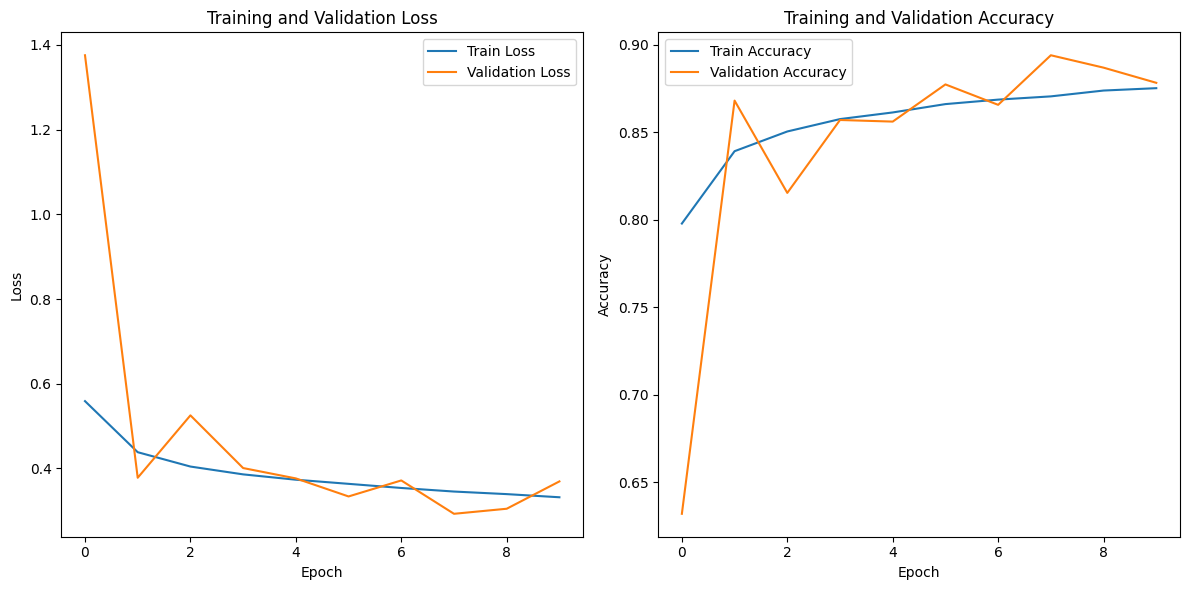

In [41]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Графік втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Показ графіків
plt.tight_layout()
plt.show()

Перевірка

1/1 [==============================] - 0s 39ms/step


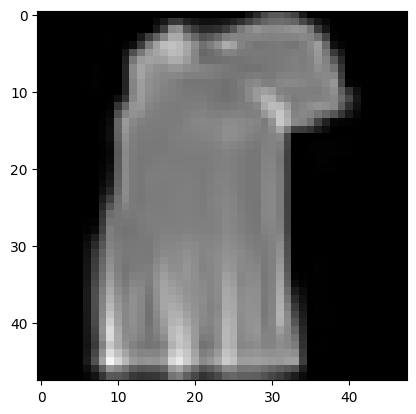

Модель передбачає: T-shirt
Правильна відповідь: T-shirt

1/1 [==============================] - 0s 49ms/step


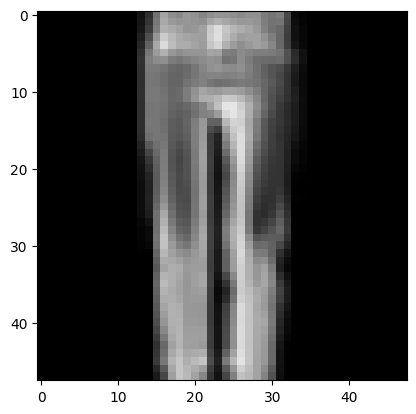

Модель передбачає: Trouser
Правильна відповідь: Trouser

1/1 [==============================] - 0s 38ms/step


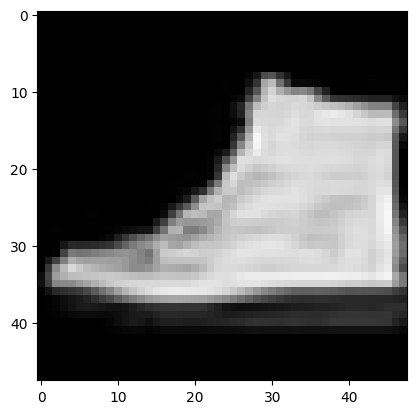

Модель передбачає: Ankle boot
Правильна відповідь: Ankle boot

1/1 [==============================] - 0s 38ms/step


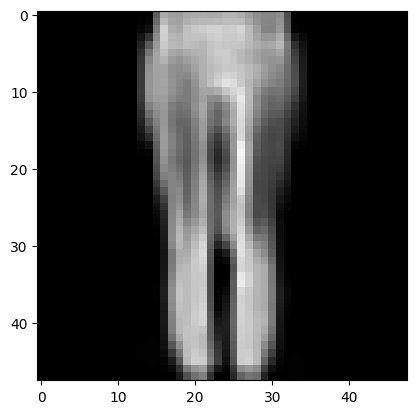

Модель передбачає: Trouser
Правильна відповідь: Trouser

1/1 [==============================] - 0s 39ms/step


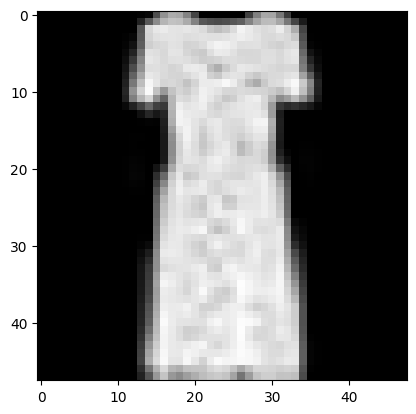

Модель передбачає: Dress
Правильна відповідь: Dress

1/1 [==============================] - 0s 40ms/step


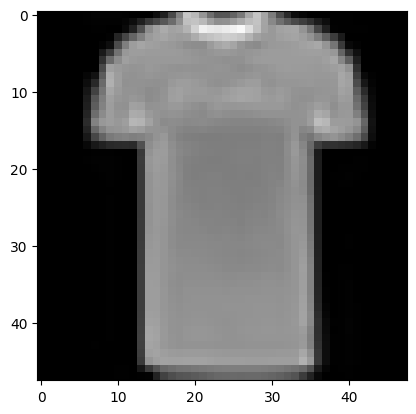

Модель передбачає: T-shirt
Правильна відповідь: T-shirt

1/1 [==============================] - 0s 39ms/step


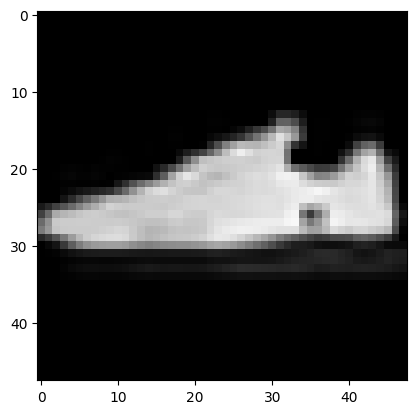

Модель передбачає: Sneaker
Правильна відповідь: Sneaker

1/1 [==============================] - 0s 39ms/step


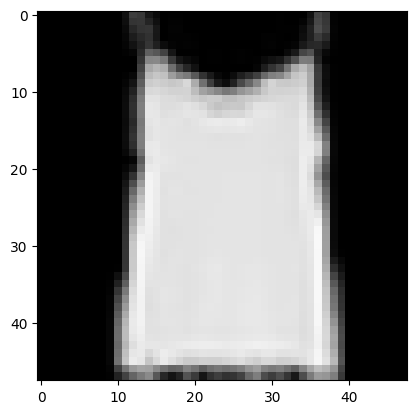

Модель передбачає: T-shirt
Правильна відповідь: T-shirt

1/1 [==============================] - 0s 43ms/step


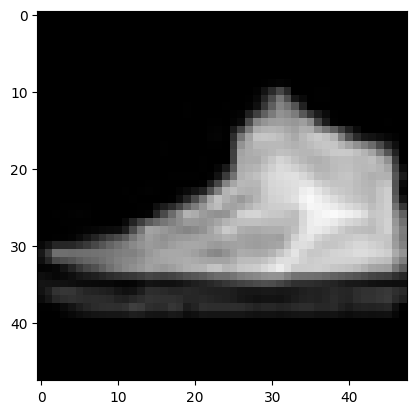

Модель передбачає: Sneaker
Правильна відповідь: Sneaker

1/1 [==============================] - 0s 38ms/step


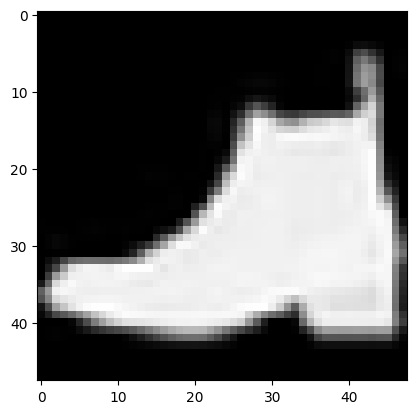

Модель передбачає: Ankle boot
Правильна відповідь: Ankle boot



In [40]:
class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
num_images = 10
random_indices = np.random.choice(x_test.shape[0], size=num_images, replace=False)

for idx in random_indices:
    # Передбачення для зображення
    test_image = np.expand_dims(x_test[idx], axis=0)
    prediction = model.predict(test_image)

    # Відображення зображення
    plt.imshow(x_test[idx].reshape(48, 48, 3))
    plt.show()

    # Передбачений та правильний клас
    predicted_class = np.argmax(prediction)
    actual_class = np.argmax(y_test[idx])

    print(f"Модель передбачає: {class_names[predicted_class]}")
    print(f"Правильна відповідь: {class_names[actual_class]}\n")

Висновки: мабуть створення моделі на основі попередньо натренованої VGG16 потребує більш складної архітектури, ніж у цьому рішенні. Я використовувала мінімальну к-сть епох, оскільки навчання відбувалося дуже довго, що видно з логів. З тієї ж причини у мене мінімум власних повнозвязних шарів, можливо їх більша кількість покращила б точність моделі. Загалом в порівнянні з попереднім завдання модель на основі VGG16 десь на на відсоток-півтора точніша. Але враховуючи складність підгону даних (ресайз зображень, приому при 48 на 48 мені вже не вистачало оперативки) та необхідність додавати 3 канали, мені більше сподобалося створювати та навчати власну згорткову мережу. І точність (91%), і швидкість навчання теж була кращою.